In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from pandas_ml import ConfusionMatrix

First we need to import the data into a dataframe using the id as our index.

In [69]:
data = pd.read_csv("Data_to_applicants.csv", index_col=0)
# drop missing data
data.dropna(inplace=True)
print(data.describe())

       radius_mean  texture_mean  perimeter_mean    area_mean  \
count   560.000000    560.000000      560.000000   560.000000   
mean     15.483830     21.138321      100.790007   717.615179   
std       3.850126      4.710128       26.566232   385.133475   
min       7.605000     10.693000       47.984000   157.168000   
25%      12.796000     17.733500       82.421000   460.574250   
50%      14.572500     20.655000       94.464500   601.240000   
75%      17.323500     23.874000      114.097500   858.944500   
max      30.802000     43.071000      206.512000  2740.072000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       560.000000        560.000000      560.000000           560.000000   
mean          0.108909          0.114143        0.095254             0.052652   
std           0.056967          0.078139        0.102124             0.067619   
min          -0.047000         -0.129000       -0.116000            -0.111000   
25%      

Next, we'll want to convert the 'diagnosis' feature to something that is machine learnable, i.e. a binary encoding where B = 0 and M = 1.

In [58]:
# convert to categorical data type
data['diagnosis'] = pd.Categorical(data['diagnosis'])
# encode as binary
data['diagnosis'] = data['diagnosis'].cat.codes

# Data Visualization

Since most of these variables are continuous, a good starting point might be to look at the histograms of each divided up into 10 bins to get an idea of how the data is distributed.

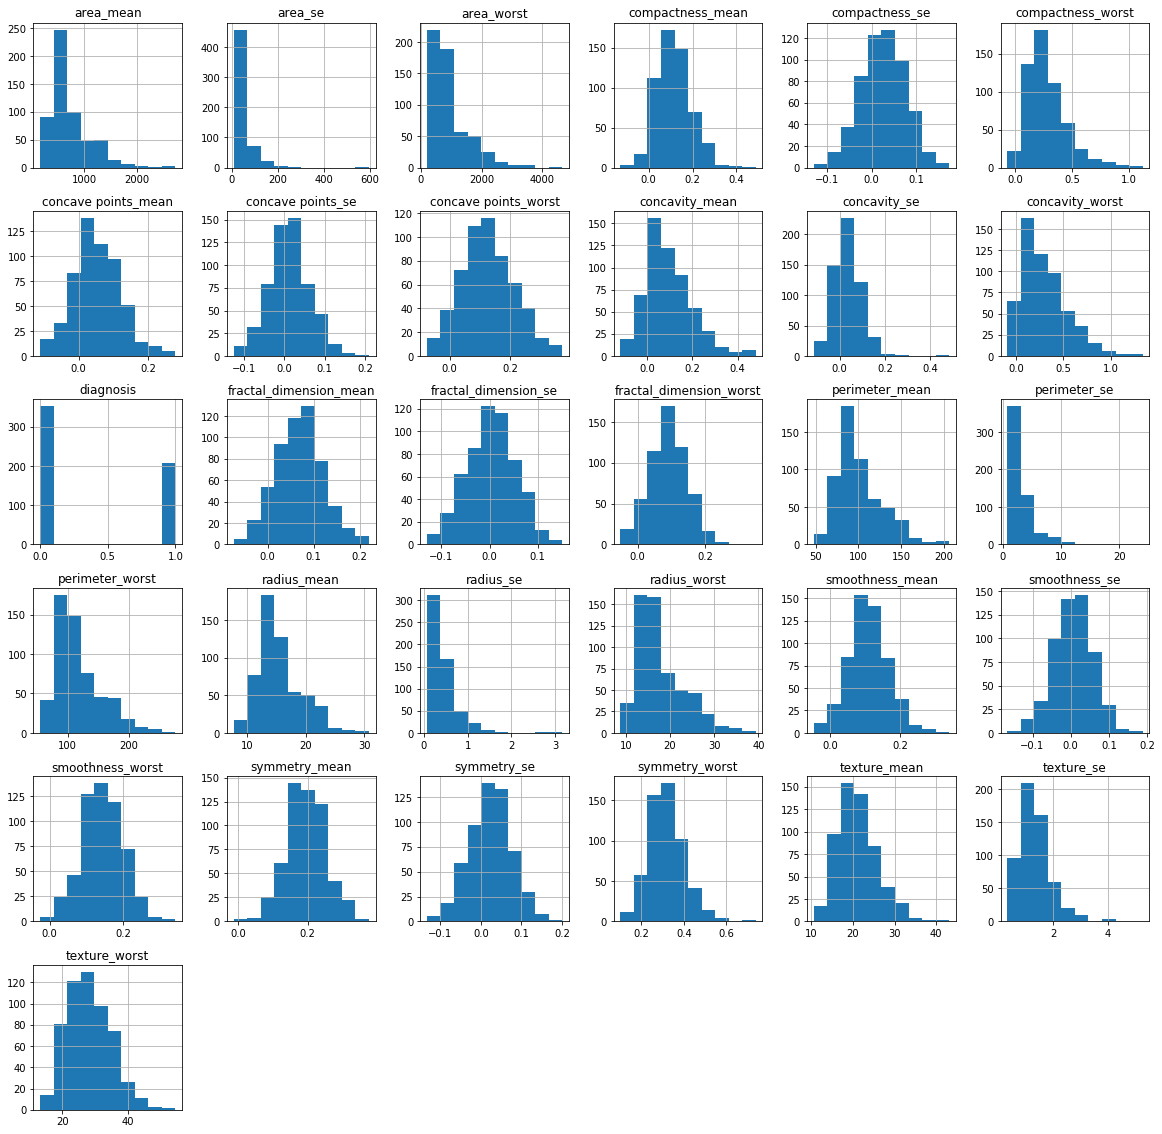

In [59]:
%matplotlib inline
# make figure size readable
plt.rcParams['figure.figsize'] = [20, 20]
data.hist()
plt.show()

Right away we can see that many of the values are not normally distributed, particularly those for area. By itself this doesn't mean much, but it could hint at its usefulness as a feature. Also notice that their are more benign than malignant tumors in the dataset, which could bias the model. Another approach we might take is to look at the pair-wise correlation of each feature to gain some sort of intuition about feature redundancy. 

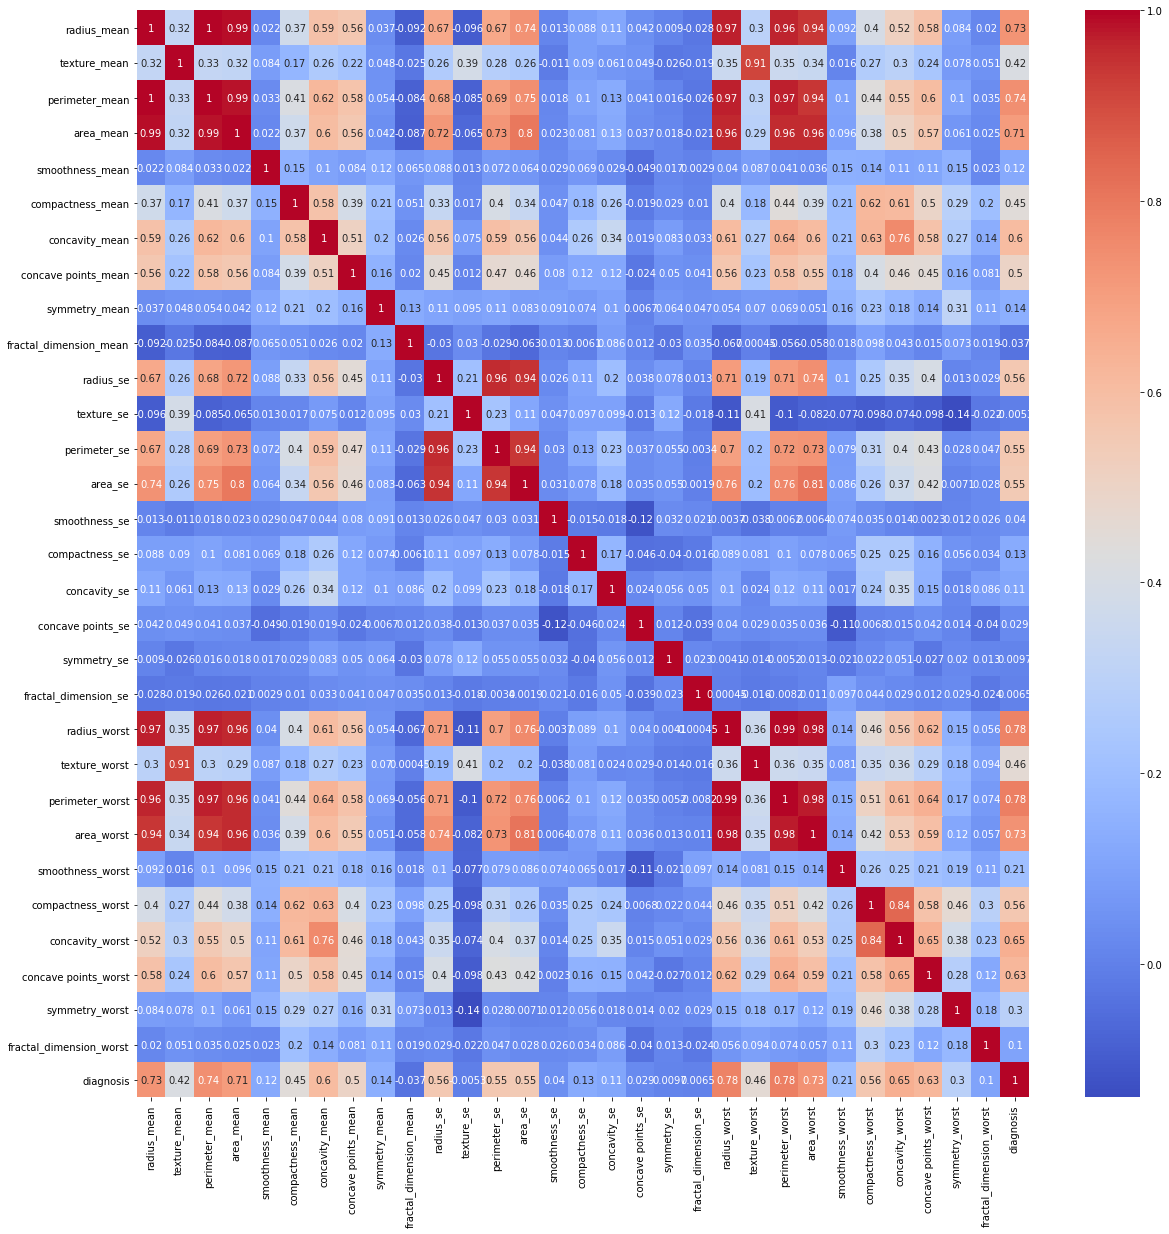

In [30]:
corr = data.iloc[:, 1:].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap="coolwarm", annot=True)
plt.show()

Each cell represents the correlation coefficient between the features on the x and y axes, with redder tones indicating more correlation and bluer tones less. As we can see, their is a significant amount of correlation between some of the features, which is a good indicator that some of these features are redundant. It should be noted that redundant features are not always a bad thing and can sometimes improve the model, however too many features only serve to increase the dimensionality and make the data harder to learn. We'll delve into this more in the next section.

# Dimensionality Reduction

Since we've already determined that there is significant redundancy in the data set, let's look at a few methods of dimensionality reduction, specifically PCA and the chi-squared test. PCA is a feature transformation algorithm, which effectively aggregates features that show high covariance. To do this, we use Eigenvectors and Eigenvalues. Recall that Eigenvectors are defined as $Av = \lambda v$, where A is our covariance matrix, v is the Eigenvector, and $\lambda$ is the Eigenvalue. If we assume that features that maximize variance along the Eigenvector (i.e. have a high Eigenvalue) exhibit higher predictive potential, we can simply take the n transformed features with the biggest Eigenvalues as our new dataset.

Another approach is the mutual information test, which works for binary classification problems such as this. It seeks to eliminate features who have low mutual information with the given classification, and therefore are unlikely to be useful for predictive modeling. One key difference between this and PCA is that PCA is a feature transformation algorithm, and the mutual information test is a feature selection algorithm. 

# Classification

Now let's try and classify the data. We'll use a logistic regression model for our first attempt as they are generally quick to train and do reasonably well with binary classification problems. For starters, we'll split our data set into testing and training sets so we can get an idea of how well the model is doing.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, :-1], data.iloc[:, -1], random_state=42)
clf = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=42)
clf.fit(X_train, y_train)
print("Logistic Regression Accuracy: {:.2f}".format(clf.score(X_test, y_test)))

Logistic Regression Accuracy: 0.92


92% isn't bad, but we could probably do better. Before we start tuning hyperparameters, let's try out a couple of other classification algorithms, specifically SVMs and Random Forests. Unlike logistic regression, an SVM (support-vector machine) is a non-probablistic linear classifier. A Random Forest on the other hand is totally non-linear, so between these three classification algorithms we should have all our bases covered (at least for a first pass).

In [51]:
svm = LinearSVC(max_iter=10000, random_state=42)
svm.fit(X_train, y_train)
print("SVM Accuracy: {:.2f}".format(svm.score(X_test, y_test)))

SVM Accuracy: 0.93
Random Forest Accuracy: 0.93


/home/johnny/miniconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
print("Random Forest Accuracy: {:.2f}".format(rf.score(X_test, y_test)))

We can see a slight performance boost when using the SVM and Random Forest models, but ultimately all of our models perform about the same. For simplicity's sake, we'll use the logistic regression model moving forward and try out the feature selection algorithms mentioned previously.

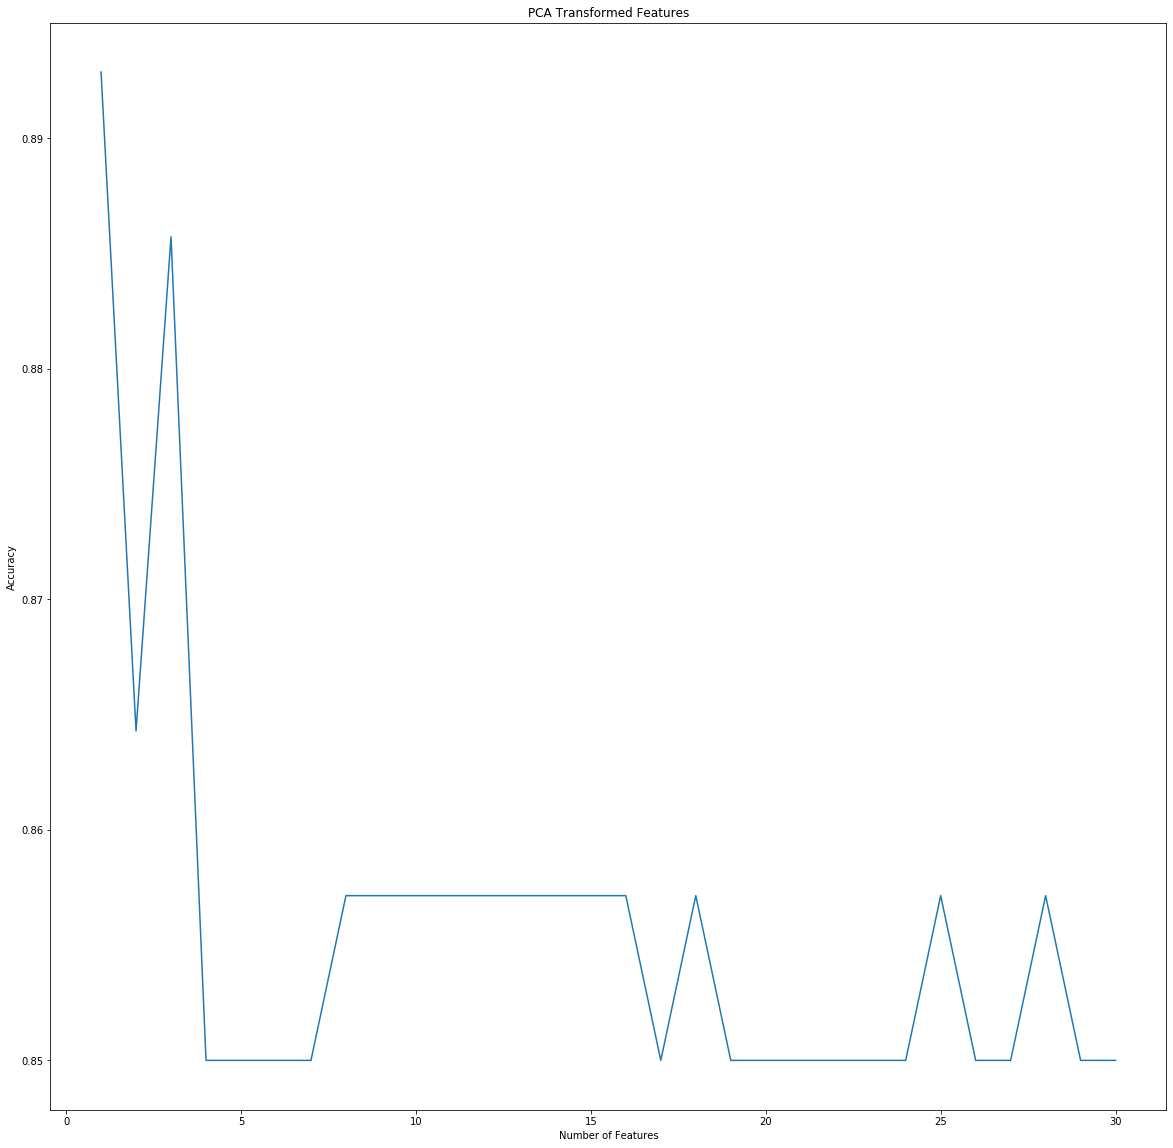

PCA Accuracy: 0.89


In [67]:
# Using PCA
scores = []
for i in range(1, len(data.columns)):
    pca = PCA(n_components=i)
    pca_train = pca.fit_transform(X_train)
    pca_test = pca.fit_transform(X_test)
    clf.fit(pca_train, y_train)
    scores.append(clf.score(pca_test, y_test))

# plot scores
plt.title("PCA Transformed Features")
plt.plot(list(range(1, len(data.columns))), scores)
plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
plt.show()
print("Best PCA Accuracy: {:.2f}".format(max(scores)))

The above graph indicates that all of the features in the dataset can be distilled into a single transformed feature. However, this feature does not perform as well as using the whole dataset. Now let's look at using the mutual information method of feature reduction.

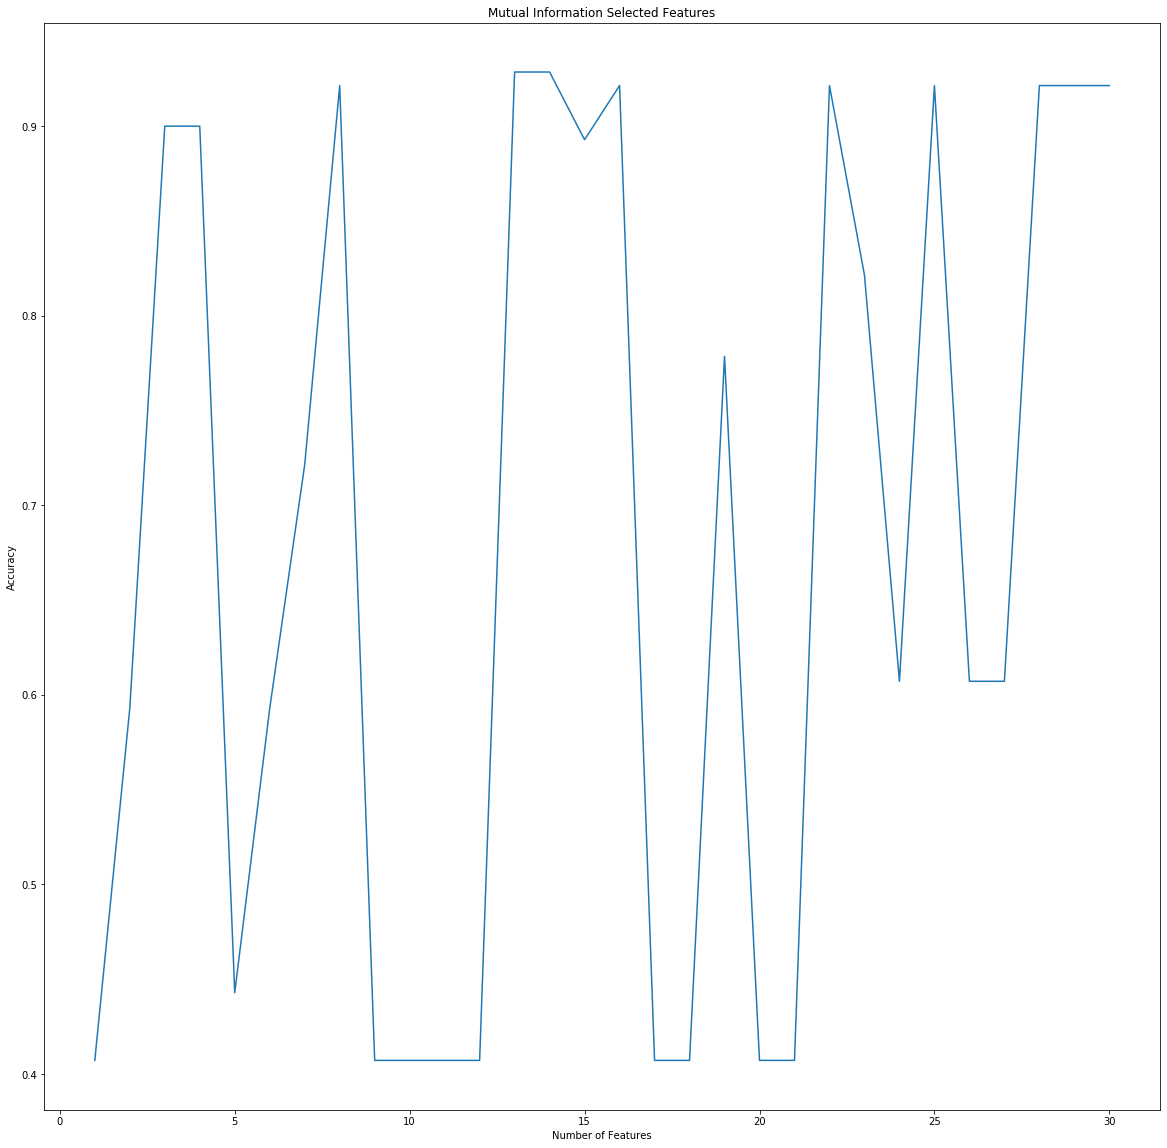

Best Mutual Information Accuracy: 0.93


In [80]:
# Using mutual info
scores = []
for i in range(1, len(data.columns)):
    f_train = SelectKBest(mutual_info_classif, k=i).fit_transform(X_train, y_train)
    f_test = SelectKBest(mutual_info_classif, k=i).fit_transform(X_test, y_test)
    clf.fit(f_train, y_train)
    scores.append(clf.score(f_test, y_test))

# plot scores
plt.title("Mutual Information Selected Features")
plt.plot(list(range(1, len(data.columns))), scores)
plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
plt.show()
print("Best Mutual Information Accuracy: {:.2f}".format(max(scores)))

There's a small performance bump here, but not as much as we might expect. What is interesting is that there are several features in the dataset that result in sharp accuracy drops. These could be due to some of the redundant features that we identified earlier, but clearly many of the features in the dataset are not useful for classification. 

# Confusion Matrix

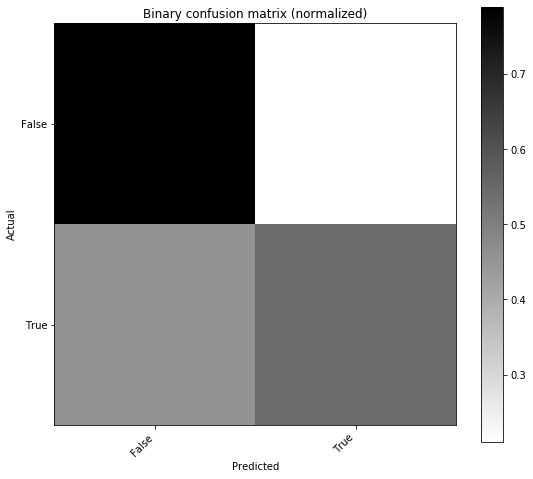

In [86]:
# get our original model back
clf = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
# plot the confusion matrix
cm = ConfusionMatrix(y_test, y_pred)
cm.plot(normalized=True)
plt.show()

The above confusion matrix shows the normalized predictions for each class, where False is benign and True is malignant. There's only so much information to be gathered from a binary confusion matrix, but perhaps the biggest takeaway is that the model does not output many false positives, but does struggle with false negatives. This ties into our earlier observation, where we noted that there were significantly more benign tumors than malignant in the data set. It is likely that this is biasing the model towards making negative predictions, and could be rectified by equalizing the number of each classification in the data.